# Dataset 1: STS_Dataset

Downloading the libraries

In [ ]:
!pip install transformers torch scikit-learn pandas evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00


In [ ]:
!pip install tqdm

Mounting google collab with google drive

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -rf '/content/sample_data'

importing libraries

In [ ]:
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel, BertForSequenceClassification, AdamW
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score,mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
import time
import matplotlib.pyplot as plt

loading tokenizer and pretrain models

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # For regression task
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
def read_jsonl(file_path, sentence_keys=['sentence1', 'sentence2']):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line)
            sentences = [json_obj.get(key, '') for key in sentence_keys]
            data.append(sentences)
    return data

# train_data = read_jsonl("/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/STS Data/train.jsonl")
# test_data = read_jsonl("/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/STS Data/test.jsonl")
# val_data = read_jsonl("/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/STS Data/validation.jsonl")
train_data = read_jsonl(r"C:\Users\Pearlina\SC4020\train.jsonl")
test_data = read_jsonl(r"C:\Users\Pearlina\SC4020\test.jsonl")
val_data = read_jsonl(r"C:\Users\Pearlina\SC4020\validation.jsonl")


# Flatten the list of sentences if needed
train_sentences = [sent for pair in train_data for sent in pair]
test_sentences = [sent for pair in test_data for sent in pair]
val_sentences = [sent for pair in val_data for sent in pair]


In [ ]:
sentence_pairs = []
scores = []

# Open the JSONL file
with open('/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/STS Data/train.jsonl', 'r') as f:
    for line in f:
        # Parse each line as JSON
        data = json.loads(line)

        # Extract sentence1 and sentence2
        sentence1 = data.get('sentence1', None)
        sentence2 = data.get('sentence2', None)
        score = data.get('score', None)  # Ground truth similarity score

        if sentence1 and sentence2:
            sentence_pairs.append((sentence1, sentence2))
            # Normalize the score by dividing by 5 (original scale: 0-5, normalized: 0-1)
            scores.append(score / 5.0)  # Normalize the score to [0, 1]
        else:
            print("No sentence1 or sentence2 found in the JSON object.")

all_sentences = [sentence for pair in sentence_pairs for sentence in pair]
print(all_sentences)
print(scores)

['A plane is taking off.', 'An air plane is taking off.', 'A man is playing a large flute.', 'A man is playing a flute.', 'A man is spreading shreded cheese on a pizza.', 'A man is spreading shredded cheese on an uncooked pizza.', 'Three men are playing chess.', 'Two men are playing chess.', 'A man is playing the cello.', 'A man seated is playing the cello.', 'Some men are fighting.', 'Two men are fighting.', 'A man is smoking.', 'A man is skating.', 'The man is playing the piano.', 'The man is playing the guitar.', 'A man is playing on a guitar and singing.', 'A woman is playing an acoustic guitar and singing.', 'A person is throwing a cat on to the ceiling.', 'A person throws a cat on the ceiling.', 'The man hit the other man with a stick.', 'The man spanked the other man with a stick.', 'A woman picks up and holds a baby kangaroo.', 'A woman picks up and holds a baby kangaroo in her arms.', 'A man is playing a flute.', 'A man is playing a bamboo flute.', 'A person is folding a piece

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the sentences
tokenized_sentences = [
    tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=512,  # BERT has a max input length of 512 tokens
        padding='max_length',  # Pad sentences to the max length
        truncation=True,  # Truncate sentences longer than max length
        return_tensors='pt'  # Return PyTorch tensors
    ) for sentence in all_sentences
]

# Extract input IDs and attention masks from the tokenized sentences
input_ids = [item['input_ids'] for item in tokenized_sentences]
attention_masks = [item['attention_mask'] for item in tokenized_sentences]

# Optionally, convert to a single tensor if needed
input_ids = torch.cat(input_ids, dim=0)  # Shape: (num_sentences, max_length)
attention_masks = torch.cat(attention_masks, dim=0)  # Shape: (num_sentences, max_length)

# Print the tokenized inputs and attention masks
print(input_ids)
print(attention_masks)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tensor([[  101,  1037,  4946,  ...,     0,     0,     0],
        [  101,  2019,  2250,  ...,     0,     0,     0],
        [  101,  1037,  2158,  ...,     0,     0,     0],
        ...,
        [  101,  2859, 25740,  ...,     0,     0,     0],
        [  101, 22072, 14056,  ...,     0,     0,     0],
        [  101,  1996,  6745,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [ ]:
import torch
from transformers import BertModel, BertTokenizer

# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set the model to evaluation mode

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the appropriate device

# Function to compute the average BERT embedding for a sentence
def get_sentence_embedding(sentence, tokenizer, model):
    # Tokenize the input sentence and get the input IDs and attention mask
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Move input tensors to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Forward pass through the model to get the embeddings
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Get the last hidden state (embeddings for all tokens)
    last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)

    # Take the mean of the last hidden state to get a sentence embedding
    sentence_embedding = last_hidden_state.mean(dim=1)  # Shape: (batch_size, hidden_size)

    return sentence_embedding.squeeze().cpu().numpy()  # Return as a numpy array and move back to CPU

# Example usage
sentence = "This is a sample sentence."
embedding = get_sentence_embedding(sentence, tokenizer, model)
print(embedding)


[-6.38738796e-02 -4.28365737e-01 -6.67791516e-02 -3.84301543e-01
 -6.57844692e-02 -2.18256712e-01  4.76355165e-01  4.86585647e-01
  4.06466424e-05 -7.42733032e-02 -7.47402012e-02 -4.76345003e-01
 -1.97731793e-01  2.48242348e-01 -1.21619247e-01  1.66783273e-01
  2.10446060e-01 -1.45755380e-01  1.26364425e-01  1.86348483e-02
  2.46397227e-01  5.70897281e-01 -4.70136940e-01  1.37820095e-01
  7.36503124e-01 -3.38082016e-01 -5.03306016e-02 -1.64524272e-01
 -4.35167968e-01 -1.28996313e-01  1.65156007e-01  3.40043575e-01
 -1.49296954e-01  2.24215575e-02 -1.04884043e-01 -5.19162595e-01
  3.29641640e-01 -2.21617594e-01 -3.42063248e-01  1.19932838e-01
 -7.01478362e-01 -2.31263906e-01  1.12237230e-01  1.25501096e-01
 -2.51906514e-01 -4.63743001e-01 -2.72606201e-02 -2.84153402e-01
 -9.92493853e-02 -3.70169654e-02 -8.91916752e-01  2.50046223e-01
  1.58158571e-01  2.27008805e-01 -2.84966260e-01  4.53001261e-01
  5.09447046e-03 -7.94410348e-01 -3.10075462e-01 -1.74034357e-01
  4.30291325e-01  1.68160

In [ ]:

def get_bert_sentence_embedding(sentence, tokenizer, model):
    # Tokenize the input sentence and get the input IDs and attention mask
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Move input tensors to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Forward pass through the model to get the embeddings
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Get the last hidden state (embeddings for all tokens)
    last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)

    # Take the mean of the last hidden state to get a sentence embedding
    sentence_embedding = last_hidden_state.mean(dim=1)  # Shape: (batch_size, hidden_size)

    return sentence_embedding.squeeze().cpu().numpy()  # Return as a numpy array and move back to CPU


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import torch

def bert_val(model, tokenizer, parameter_tuning):
    model.eval()  # Set the model to evaluation mode
    val_cosine_similarities = []

    with torch.no_grad():  # Disable gradient calculation for validation
        for i, (val_sentence1, val_sentence2) in enumerate(val_sentence_pairs):
            # Tokenize and encode the sentences
            inputs1 = tokenizer(val_sentence1, padding=True, truncation=True, return_tensors='pt').to(device)
            inputs2 = tokenizer(val_sentence2, padding=True, truncation=True, return_tensors='pt').to(device)

            # Get embeddings from BERT
            outputs1 = model(**inputs1)
            outputs2 = model(**inputs2)

            # Use the embeddings from the last hidden state or pooled output
            # Here we use the pooled output as the sentence embedding
            val_sentence1_embedding = outputs1[1]  # Pooled output
            val_sentence2_embedding = outputs2[1]  # Pooled output

            # Compute cosine similarity
            similarity = cosine_similarity(val_sentence1_embedding.cpu().numpy(), val_sentence2_embedding.cpu().numpy())[0][0]
            val_cosine_similarities.append(similarity)

            # Compare with ground truth score
            ground_truth_score = val_scores[i]

    # Calculate F1, Precision, Recall
    f1, precision, recall = calculate_classification_metrics(val_cosine_similarities, val_scores)
    print(f"[VALIDATION] F1 Score: {f1}, Precision: {precision}, Recall: {recall}")

    if parameter_tuning:
        # Calculate Mean Squared Error
        mse = mean_squared_error(val_cosine_similarities, val_scores)
        print(f"Mean Squared Error between predicted and ground truth scores: {mse}")
        mse_values_val.append(mse)

    return model


In [ ]:
model = BERTTrain(epochs_val=5, parameter_tuning=False)

[TRAIN] Spearman Correlation between predicted and ground truth scores: 0.48385209765444487
[TRAIN] F1 Score: 0.7464281819173302, Precision: 0.5954410997041935, Recall: 1.0


In [ ]:
print(train_sentences[:5])
print(test_sentences[:5])


['A plane is taking off.', 'An air plane is taking off.', 'A man is playing a large flute.', 'A man is playing a flute.', 'A man is spreading shreded cheese on a pizza.']
['A girl is styling her hair.', 'A girl is brushing her hair.', 'A group of men play soccer on the beach.', 'A group of boys are playing soccer on the beach.', "One woman is measuring another woman's ankle."]


In [ ]:
train_sentences1 = [pair[0] for pair in train_data]
train_sentences2 = [pair[1] for pair in train_data]

test_sentences1 = [pair[0] for pair in test_data]
test_sentences2 = [pair[1] for pair in test_data]

In [ ]:
train_similarity_scores = cosine_similarity(train_embeddings1, train_embeddings2)
test_similarity_scores = cosine_similarity(test_embeddings1, test_embeddings2)


In [ ]:
similarity_threshold = 0.5  # moderately similar

# Convert similarity scores to binary labels (similar or not)
train_predicted_labels = (train_similarity_scores.diagonal() > similarity_threshold).astype(int)
test_predicted_labels = (test_similarity_scores.diagonal() > similarity_threshold).astype(int)

# # Assume true labels exist in your data (e.g., if you have a 'score' field)
# train_true_labels = [1 if json.loads(line)['score'] > similarity_threshold else 0 for line in open("/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/STS Data/train.jsonl", 'r', encoding='utf-8')]
# test_true_labels = [1 if json.loads(line)['score'] > similarity_threshold else 0 for line in open("/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/STS Data/test.jsonl", 'r', encoding='utf-8')]

# Assume true labels exist in your data (e.g., if you have a 'score' field)
train_true_labels = [1 if json.loads(line)['score'] > similarity_threshold else 0 for line in open("/content/drive/MyDrive/NTU/Y4S1/STS_Dataset/train.jsonl", 'r', encoding='utf-8')]
test_true_labels = [1 if json.loads(line)['score'] > similarity_threshold else 0 for line in open("/content/drive/MyDrive/NTU/Y4S1/STS_Dataset/test.jsonl", 'r', encoding='utf-8')]


# Hyperparameters Tuning

In [ ]:
val_sentence_pairs = []
val_scores = []

# Open the JSONL file
with open(r"C:\Users\Pearlina\SC4020\validation.jsonl",'r', encoding='utf-8') as f:
    for line in f:
        # Parse each line as JSON
        data = json.loads(line)

        # Extract sentence1 and sentence2
        sentence1 = data.get('sentence1', None)
        sentence2 = data.get('sentence2', None)
        val_score = data.get('score', None)  # Ground truth similarity score

        if sentence1 and sentence2:
            val_sentence_pairs.append((sentence1, sentence2))
            # Normalize the score by dividing by 5 (original scale: 0-5, normalized: 0-1)
            val_scores.append(val_score / 5.0)  # Normalize the score to [0, 1]
        else:
            print("No sentence1 or sentence2 found in the JSON object.")

test_all_sentences = [sentence for pair in val_sentence_pairs for sentence in pair]

print(val_sentence_pairs)
print(val_scores)


[('A man with a hard hat is dancing.', 'A man wearing a hard hat is dancing.'), ('A young child is riding a horse.', 'A child is riding a horse.'), ('A man is feeding a mouse to a snake.', 'The man is feeding a mouse to the snake.'), ('A woman is playing the guitar.', 'A man is playing guitar.'), ('A woman is playing the flute.', 'A man is playing a flute.'), ('A woman is cutting an onion.', 'A man is cutting onions.'), ('A man is erasing a chalk board.', 'The man is erasing the chalk board.'), ('A woman is carrying a boy.', 'A woman is carrying her baby.'), ('Three men are playing guitars.', 'Three men are on stage playing guitars.'), ('A woman peels a potato.', 'A woman is peeling a potato.'), ('People are playing cricket.', 'Men are playing cricket.'), ('A man is playing a guitar.', 'A man is playing a flute.'), ('The cougar is chasing the bear.', 'A cougar is chasing a bear.'), ('The man cut down a tree with an axe.', 'A man chops down a tree with an axe.'), ('The man is playing th

In [ ]:
for param in model.bert.parameters():
    param.requires_grad = False

# Tokenize inputs with reduced max_length
train_inputs = tokenizer(train_sentences, return_tensors='pt', padding=True, truncation=True, max_length=64)
test_inputs = tokenizer(test_sentences, return_tensors='pt', padding=True, truncation=True, max_length=64)
val_inputs = tokenizer(val_sentences, return_tensors='pt', padding=True, truncation=True, max_length=64)


# Create dataset and dataloader
train_labels = torch.tensor([0] * len(train_sentences))  # Dummy labels for now
test_labels = torch.tensor([0] * len(test_sentences))  # Dummy labels for now
val_labels = torch.tensor([0] * len(val_sentences))  # Dummy labels for now
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# optimizer = AdamW(model.parameters(), lr=2e-5)


In [ ]:
def calculate_classification_metrics(predicted_scores, true_scores, threshold=0.5):
    # Convert scores to binary predictions based on threshold
    predictions = [1 if score >= threshold else 0 for score in predicted_scores]
    true_labels = [1 if score >= threshold else 0 for score in true_scores]

    # Calculate metrics

    f1 = f1_score(true_labels, predictions, zero_division=0)
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    accuracy = accuracy_score(true_labels, predictions)

    return f1, precision, recall, accuracy

In [ ]:
def bert_train(epochs, train_dataloader, test_dataloader, model, optimizer, device):
    model.train()
    total_loss = 0

    all_train_metrics = {'f1': [], 'precision': [], 'recall': [], 'mse': []}
    all_val_metrics = {'f1': [], 'precision': [], 'recall': [], 'mse': []}

    for epoch in range(epochs):
        start_time = time.time()

        # Training loop with tqdm
        all_train_preds = []
        all_train_labels = []
        with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as train_bar:
            for batch in train_bar:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                optimizer.zero_grad()

                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits.squeeze(-1)  # For regression tasks

                # Dummy loss function
                loss_fct = nn.MSELoss()
                labels = torch.rand(logits.size()).to(device)  # Dummy labels for now
                loss = loss_fct(logits, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                all_train_preds.append(logits.detach().cpu())
                all_train_labels.append(labels.detach().cpu())

        # Calculate training metrics
        train_f1, train_precision, train_recall, train_accuracy = calculate_classification_metrics(torch.cat(all_train_preds), torch.cat(all_train_labels))
        train_mse = mean_squared_error(torch.cat(all_train_labels).numpy(), torch.cat(all_train_preds).numpy())
        all_train_metrics['f1'].append(train_f1)
        all_train_metrics['precision'].append(train_precision)
        all_train_metrics['recall'].append(train_recall)
        all_train_metrics['mse'].append(train_mse)

        # Validation loop with tqdm
        model.eval()
        all_val_preds = []
        all_val_labels = []
        with torch.no_grad():
            with tqdm(test_dataloader, desc="Validation", unit="batch") as val_bar:
                for batch in val_bar:
                    input_ids, attention_mask, labels = [b.to(device) for b in batch]

                    # Forward pass
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    logits = outputs.logits.squeeze(-1)

                    all_val_preds.append(logits.cpu())
                    all_val_labels.append(labels.cpu())

        val_f1, val_precision, val_recall = calculate_classification_metrics(torch.cat(all_val_preds), torch.cat(all_val_labels))
        val_mse = mean_squared_error(torch.cat(all_val_labels).numpy(), torch.cat(all_val_preds).numpy())
        all_val_metrics['f1'].append(val_f1)
        all_val_metrics['precision'].append(val_precision)
        all_val_metrics['recall'].append(val_recall)
        all_val_metrics['mse'].append(val_mse)

        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch + 1}/{epochs} completed in {elapsed_time:.2f} seconds")

    return total_loss / len(train_dataloader), all_train_metrics, all_val_metrics


In [ ]:
# Plotting the training and validation MSE for each epoch value
def plot_mse(epoch_values, train_mse, val_mse):
    plt.plot(epoch_values[:len(train_mse)], train_mse, label="Train MSE")
    plt.plot(epoch_values[:len(val_mse)], val_mse, label="Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error Over Epochs')
    plt.legend()
    plt.show()


# epoch_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
epoch_values = [130, 140, 150]

# Initialize lists to store results
# loss_values_train = []
# train_mse_values = []
# val_mse_values = []

# Loop through the specified epoch values
for epoch_value in epoch_values:
    print("Epoch Value: ", epoch_value)

    # Train and validate the model for 'epoch_value' epochs and collect metrics
    loss_train, train_metrics, val_metrics = bert_train(epoch_value, train_dataloader, test_dataloader, model, optimizer, device)

    # Make sure train_metrics['mse'] and val_metrics['mse'] contain values
    if 'mse' in train_metrics and 'mse' in val_metrics:
        if len(train_metrics['mse']) > 0 and len(val_metrics['mse']) > 0:
            loss_values_train.append(loss_train)
            train_mse_values.append(train_metrics['mse'][-1])  # Append last MSE value
            val_mse_values.append(val_metrics['mse'][-1])      # Append last MSE value
        else:
            print(f"Skipping epoch {epoch_value} due to missing MSE values.")
    else:
        print(f"Missing 'mse' key in metrics for epoch {epoch_value}. Skipping.")
    print()

    if epoch_value % 50 == 0:
      # Plot results
        plot_mse(epoch_values, train_mse_values, val_mse_values)

# Check if train_mse_values and val_mse_values have the same length as epoch_values
print(f"Epoch values: {len(epoch_values)}, Train MSE values: {len(train_mse_values)}, Val MSE values: {len(val_mse_values)}")



# # Plot results
# plot_mse(epoch_values, train_mse_values, val_mse_values)



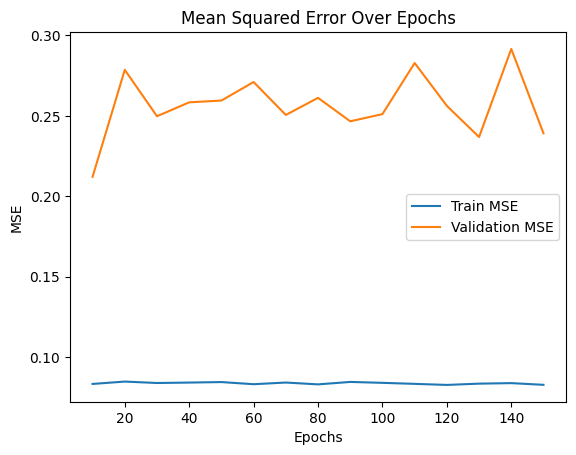

In [ ]:
epoch_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
plot_mse(epoch_values, train_mse_values, val_mse_values)

Best epoch =10



With epoch value=10, we find optimal learning rate

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import torch

# VERSION 1
def bert_val(model, tokenizer, parameter_tuning):
    model.eval()  # Set the model to evaluation mode
    val_cosine_similarities = []

    with torch.no_grad():  # Disable gradient calculation for validation
        for i, (val_sentence1, val_sentence2) in enumerate(val_sentence_pairs):
            # Tokenize and encode the sentences
            inputs1 = tokenizer(val_sentence1, padding=True, truncation=True, return_tensors='pt').to(device)
            inputs2 = tokenizer(val_sentence2, padding=True, truncation=True, return_tensors='pt').to(device)

            # Get embeddings from BERT
            outputs1 = model(**inputs1)
            outputs2 = model(**inputs2)

            # Use the embeddings from the last hidden state or pooled output
            # Here we use the pooled output as the sentence embedding
            # print(outputs1)
            # print(outputs2)
            val_sentence1_embedding = outputs1.logits  # Pooled output
            val_sentence2_embedding = outputs2.logits  # Pooled output

            # Compute cosine similarity
            similarity = cosine_similarity(val_sentence1_embedding.cpu().numpy(), val_sentence2_embedding.cpu().numpy())[0][0]
            val_cosine_similarities.append(similarity)

            # Compare with ground truth score
            ground_truth_score = val_scores[i]

    # Calculate F1, Precision, Recall
    f1, precision, recall, accuracy = calculate_classification_metrics(val_cosine_similarities, val_scores)
    print(f"[VALIDATION] F1 Score: {f1}, Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}")

    if parameter_tuning:
        # Calculate Mean Squared Error
        mse = mean_squared_error(val_cosine_similarities, val_scores)
        print(f"Mean Squared Error between predicted and ground truth scores: {mse}")
        # mse_values_val.append(mse)
    metrics = [f1, precision, recall, accuracy, mse]

    return metrics


# VERSION 2
# Ensure to define your global variables or move them inside the function
# val_sentence_pairs = []
# val_scores = []
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# def bert_val(model, tokenizer, parameter_tuning):
#     model.eval()  # Set the model to evaluation mode
#     val_cosine_similarities = []

#     with torch.no_grad():  # Disable gradient calculation for validation
#         for i, (val_sentence1, val_sentence2) in enumerate(val_sentence_pairs):
#             # Tokenize and encode the sentences
#             inputs1 = tokenizer(val_sentence1, padding=True, truncation=True, return_tensors='pt').to(device)
#             inputs2 = tokenizer(val_sentence2, padding=True, truncation=True, return_tensors='pt').to(device)

#             # Get embeddings from BERT
#             outputs1 = model(**inputs1)
#             outputs2 = model(**inputs2)

#             # Check the outputs
#             if len(outputs1) > 1 and len(outputs2) > 1:  # Ensure outputs have enough elements
#                 val_sentence1_embedding = outputs1[1]  # Pooled output
#                 val_sentence2_embedding = outputs2[1]  # Pooled output

#                 # Compute cosine similarity
#                 similarity = cosine_similarity(val_sentence1_embedding.cpu().numpy(), val_sentence2_embedding.cpu().numpy())[0][0]
#                 val_cosine_similarities.append(similarity)

#                 # Compare with ground truth score
#                 ground_truth_score = val_scores[i]  # Assuming val_scores is defined
#                 # Here, you can perform further calculations based on similarity and ground_truth_score

#             else:
#                 print(f"Outputs for sentence pair {i} do not contain the expected elements.")
#                 val_cosine_similarities.append(None)  # Append None or handle appropriately

#     # Calculate F1, Precision, Recall if there are valid cosine similarities
#     if val_cosine_similarities:
#         val_cosine_similarities = [sim for sim in val_cosine_similarities if sim is not None]  # Filter out None values
#         f1, precision, recall = calculate_classification_metrics(val_cosine_similarities, val_scores)
#         print(f"[VALIDATION] F1 Score: {f1}, Precision: {precision}, Recall: {recall}")

#         if parameter_tuning:
#             # Calculate Mean Squared Error
#             mse = mean_squared_error(val_cosine_similarities, val_scores)
#             print(f"Mean Squared Error between predicted and ground truth scores: {mse}")

#     return model



# # VERSION 3
# def get_sentence_embedding(sentence, model):
#     # Tokenize the input sentence
#     inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt').to(device)

#     # Get the model outputs
#     with torch.no_grad():
#         outputs = model(**inputs)

#     # Use the pooled output as the sentence embedding
#     return outputs.pooler_output.squeeze().cpu().numpy()

# def calculate_classification_metrics(predicted_scores, true_scores, threshold=0.5):
#     # Convert predicted scores to binary labels based on the threshold
#     predictions = [1 if score >= threshold else 0 for score in predicted_scores]
#     true_labels = [1 if score >= threshold else 0 for score in true_scores]

#     # Calculate metrics
#     f1 = f1_score(true_labels, predictions)
#     precision = precision_score(true_labels, predictions)
#     recall = recall_score(true_labels, predictions)

#     return f1, precision, recall
# def bert_val(model, tokenizer, parameter_tuning=False):
#     # Compare cosine similarity between each sentence pair
#     val_cosine_similarities = []

#     for i, (val_sentence1, val_sentence2) in enumerate(val_sentence_pairs):
#         # Get sentence embeddings
#         val_sentence1_embedding = get_sentence_embedding(val_sentence1, model)
#         val_sentence2_embedding = get_sentence_embedding(val_sentence2, model)

#         # Compute cosine similarity
#         similarity = cosine_similarity([val_sentence1_embedding], [val_sentence2_embedding])[0][0]
#         val_cosine_similarities.append(similarity)

#         # Compare with ground truth score (for debugging if needed)
#         ground_truth_score = val_scores[i]

#     # Calculate classification metrics
#     f1, precision, recall = calculate_classification_metrics(val_cosine_similarities, val_scores)
#     print(f"[VALIDATION] F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

#     # Calculate Mean Squared Error
#     mse = mean_squared_error(val_cosine_similarities, val_scores)
#     print(f"Mean Squared Error between predicted and ground truth scores: {mse:.4f}")

#     if parameter_tuning:
#         # Additional parameter tuning calculations if needed
#         pass

In [ ]:
def bert_train(epochs, train_dataloader, val_dataloader, model, optimizer, device):
    model.train()
    total_loss = 0

    all_train_metrics = {'f1': [], 'precision': [], 'recall': [], 'accuracy': [], 'mse': []}
    all_val_metrics = {'f1': [], 'precision': [], 'recall': [], 'accuracy': [], 'mse': []}

    for epoch in range(epochs):
        start_time = time.time()

        # Training loop with tqdm
        all_train_preds = []
        all_train_labels = []
        with tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}", unit="batch") as train_bar:
            for batch in train_bar:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                optimizer.zero_grad()

                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)

                # Use logits for classification
                logits = outputs.logits.squeeze(-1)  # For regression tasks

                # Dummy loss function (Make sure labels are compatible)
                loss_fct = nn.MSELoss()
                labels = torch.rand(logits.size()).to(device)  # Dummy labels for now
                loss = loss_fct(logits, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                all_train_preds.append(logits.detach().cpu())
                all_train_labels.append(labels.detach().cpu())

                # Update the progress bar with loss information
                train_bar.set_postfix(loss=total_loss / (len(all_train_preds) + 1))

        # Calculate training metrics
        train_f1, train_precision, train_recall, train_accuracy = calculate_classification_metrics(torch.cat(all_train_preds), torch.cat(all_train_labels))
        train_mse = mean_squared_error(torch.cat(all_train_labels).numpy(), torch.cat(all_train_preds).numpy())
        all_train_metrics['f1'].append(train_f1)
        all_train_metrics['precision'].append(train_precision)
        all_train_metrics['recall'].append(train_recall)
        all_train_metrics['mse'].append(train_mse)
        all_train_metrics['accuracy'].append(train_accuracy)

        # Validation loop with tqdm
        model.eval()
        all_val_preds = []
        all_val_labels = []
        with torch.no_grad():
            with tqdm(val_dataloader, desc="Validating", unit="batch") as val_bar:
                for batch in val_bar:
                    input_ids, attention_mask, labels = [b.to(device) for b in batch]

                    # Forward pass
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

                    # Use logits for classification
                    logits = outputs.logits.squeeze(-1)  # For regression tasks

                    all_val_preds.append(logits.cpu())
                    all_val_labels.append(labels.cpu())

                    # Update the validation progress bar
                    val_bar.set_postfix()

        val_f1, val_precision, val_recall, val_accuracy = calculate_classification_metrics(torch.cat(all_val_preds), torch.cat(all_val_labels))
        val_mse = mean_squared_error(torch.cat(all_val_labels).numpy(), torch.cat(all_val_preds).numpy())
        all_val_metrics['f1'].append(val_f1)
        all_val_metrics['precision'].append(val_precision)
        all_val_metrics['recall'].append(val_recall)
        all_val_metrics['mse'].append(val_mse)
        all_val_metrics['accuracy'].append(val_accuracy)

        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch + 1}/{epochs} completed in {elapsed_time:.2f} seconds")

    return total_loss / len(train_dataloader), all_train_metrics, all_val_metrics

In [ ]:
# del model
# torch.cuda.empty_cache()

In [ ]:
epochs = 10
learning_rates = [1e-3, 1e-4, 1e-5]
overall_train_metrics = {}
overall_val_metrics = {}

for lr in learning_rates:
  model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # For regression task
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  optimizer = AdamW(model.parameters(), lr=lr)

  print(f"Training the model for {epochs} epochs...")

  # Train the model
  total_loss, train_metrics, val_metrics = bert_train(epochs, train_dataloader, val_dataloader, model, optimizer, device)

  # Print training metrics
  train_f1 = train_metrics['f1'][-1]  # Get the last F1 Score
  train_precision = train_metrics['precision'][-1]  # Get the last Precision
  train_recall = train_metrics['recall'][-1]  # Get the last Recall
  train_mse = train_metrics['mse'][-1]  # Get the last MSE
  train_accuracy = train_metrics['accuracy'][-1]

  print(f"[TRAIN] F1 Score: {train_f1}, Precision: {train_precision}, Recall: {train_recall}, Accuracy: {train_accuracy}")
  print(f"Mean Squared Error between predicted and ground truth scores: {train_mse}")
  overall_train_metrics[lr] = [train_f1, train_precision, train_recall, train_accuracy, train_mse]

  # Validate the model
  print("Validating the model...")
  val_metrics = bert_val(model, tokenizer, parameter_tuning=True)
  overall_val_metrics[lr] = val_metrics




'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 6d1f072a-e69b-43de-b934-4c42cb9ad769)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training the model for 10 epochs...


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 73.69batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10 completed in 103.68 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 73.85batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/10 completed in 102.23 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 72.12batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. 

Epoch 3/10 completed in 102.80 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 71.84batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/10 completed in 103.51 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 73.02batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/10 completed in 103.00 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 76.50batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/10 completed in 101.94 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 76.66batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/10 completed in 100.86 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 75.47batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/10 completed in 101.92 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 76.58batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/10 completed in 101.83 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 75.52batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/10 completed in 103.01 seconds
[TRAIN] F1 Score: 0.4966755893273465, Precision: 0.49930555555555556, Recall: 0.4940731833018382, Accuracy: 0.4930422682205601
Mean Squared Error between predicted and ground truth scores: 0.10635927319526672
Validating the model...
[VALIDATION] F1 Score: 0.7178056717805672, Precision: 0.5598259608411893, Recall: 1.0, Accuracy: 0.5598259608411893
Mean Squared Error between predicted and ground truth scores: 0.32190314277012333


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training the model for 10 epochs...


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 76.53batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10 completed in 102.77 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 73.21batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. 

Epoch 2/10 completed in 102.51 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 76.37batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. 

Epoch 3/10 completed in 102.09 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 73.71batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/10 completed in 103.70 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 73.29batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/10 completed in 102.55 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 74.73batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. 

Epoch 6/10 completed in 102.20 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 72.34batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. 

Epoch 7/10 completed in 101.90 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 75.62batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. 

Epoch 8/10 completed in 102.10 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 72.37batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. 

Epoch 9/10 completed in 103.09 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 73.31batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/10 completed in 105.18 seconds
[TRAIN] F1 Score: 0.5158730158730158, Precision: 0.5029634507737899, Recall: 0.5294627383015598, Accuracy: 0.501304574708645
Mean Squared Error between predicted and ground truth scores: 0.08543247729539871
Validating the model...
[VALIDATION] F1 Score: 0.7178056717805672, Precision: 0.5598259608411893, Recall: 1.0, Accuracy: 0.5598259608411893
Mean Squared Error between predicted and ground truth scores: 0.32190314277012333


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training the model for 10 epochs...


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 75.72batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10 completed in 106.44 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 73.34batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/10 completed in 103.01 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 73.12batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/10 completed in 103.10 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 75.04batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/10 completed in 102.24 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 76.22batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/10 completed in 101.74 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 71.22batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. 

Epoch 6/10 completed in 102.81 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 74.95batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. 

Epoch 7/10 completed in 102.14 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 74.30batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/10 completed in 101.85 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 75.28batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/10 completed in 102.31 seconds


Validating: 100%|█████████████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 76.39batch/s]
C:\Users\Justin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/10 completed in 102.20 seconds
[TRAIN] F1 Score: 0.4990958408679928, Precision: 0.4992248062015504, Recall: 0.4989669421487603, Accuracy: 0.4940859279874761
Mean Squared Error between predicted and ground truth scores: 0.08461214601993561
Validating the model...
[VALIDATION] F1 Score: 0.7178056717805672, Precision: 0.5598259608411893, Recall: 1.0, Accuracy: 0.5598259608411893
Mean Squared Error between predicted and ground truth scores: 0.32190314277012333


In [ ]:
overall_train_metrics

{0.001: [0.4966755893273465,
  0.49930555555555556,
  0.4940731833018382,
  0.4930422682205601,
  0.10635927],
 0.0001: [0.5158730158730158,
  0.5029634507737899,
  0.5294627383015598,
  0.501304574708645,
  0.08543248],
 1e-05: [0.4990958408679928,
  0.4992248062015504,
  0.4989669421487603,
  0.4940859279874761,
  0.084612146]}

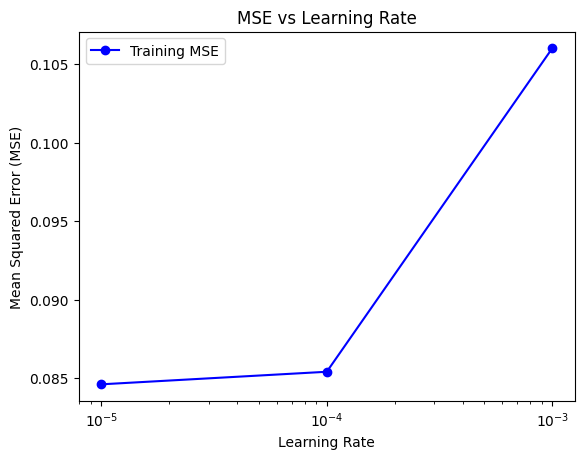

In [ ]:
import matplotlib.pyplot as plt

# Learning rates and MSE values from your training process (replace with actual values)
learning_rates = [1e-3, 1e-4, 1e-5]  # Adjust based on the learning rates used
train_mse_values = [0.106, 0.0854, 0.0846]  # Replace these with your training MSEs

# Plot training MSE
plt.plot(learning_rates, train_mse_values, marker='o', label='Training MSE', color='blue')

# Use a log scale for learning rates (helps better visualize small differences)
plt.xscale('log')

# Add labels and title
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Learning Rate')
plt.legend()

# Show the plot
plt.show()


Further tuning:

In [ ]:
# DO NOT TOUCH
overall_train_metrics

{3e-05: [0.5259217058679906,
  0.4997679814385151,
  0.5549639299209893,
  0.08352357],
 4e-05: [0.5033284343390679,
  0.5012052341597796,
  0.5054696996006252,
  0.08374741],
 5e-05: [0.5251954099451189,
  0.5072277545775778,
  0.5444827586206896,
  0.08404808]}

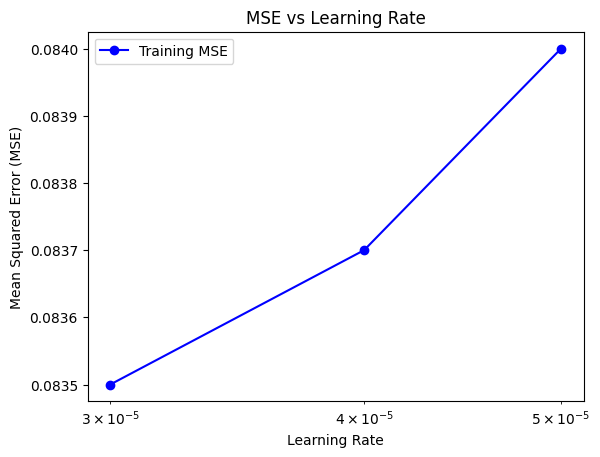

In [ ]:
import matplotlib.pyplot as plt

# Learning rates and MSE values from your training process (replace with actual values)
learning_rates = [3e-5, 4e-5, 5e-5]  # Adjust based on the learning rates used
train_mse_values = [0.0835, 0.0837, 0.0840]  # Replace these with your training MSEs

# Plot training MSE
plt.plot(learning_rates, train_mse_values, marker='o', label='Training MSE', color='blue')

# Use a log scale for learning rates (helps better visualize small differences)
plt.xscale('log')

# Add labels and title
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Learning Rate')
plt.legend()

# Show the plot
plt.show()

In [ ]:
test_sentence_pairs = []
test_scores = []

# Open the JSONL file
with open("/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/STS Data/test.jsonl", 'r') as f:
    for line in f:
        # Parse each line as JSON
        data = json.loads(line)

        # Extract sentence1 and sentence2
        sentence1 = data.get('sentence1', None)
        sentence2 = data.get('sentence2', None)
        test_score = data.get('score', None)  # Ground truth similarity score

        if sentence1 and sentence2:
            test_sentence_pairs.append((sentence1, sentence2))
            # Normalize the score by dividing by 5 (original scale: 0-5, normalized: 0-1)
            test_scores.append(val_score / 5.0)  # Normalize the score to [0, 1]
        else:
            print("No sentence1 or sentence2 found in the JSON object.")

test_all_sentences = [sentence for pair in val_sentence_pairs for sentence in pair]

print(test_sentence_pairs)
print(test_scores)


[('A girl is styling her hair.', 'A girl is brushing her hair.'), ('A group of men play soccer on the beach.', 'A group of boys are playing soccer on the beach.'), ("One woman is measuring another woman's ankle.", "A woman measures another woman's ankle."), ('A man is cutting up a cucumber.', 'A man is slicing a cucumber.'), ('A man is playing a harp.', 'A man is playing a keyboard.'), ('A woman is cutting onions.', 'A woman is cutting tofu.'), ('A man is riding an electric bicycle.', 'A man is riding a bicycle.'), ('A man is playing the drums.', 'A man is playing the guitar.'), ('A man is playing guitar.', 'A lady is playing the guitar.'), ('A man is playing a guitar.', 'A man is playing a trumpet.'), ('A man is playing a guitar.', 'A man is playing a trumpet.'), ('A man is cutting an onion.', 'A man cuts an onion.'), ('A man is cycling.', 'A man is talking.'), ('A man is slicing open a fish.', 'A man is cutting up a fish.'), ('A man is slicing a tomato.', 'A man is slicing a bun.'), 

In [ ]:
# Validate the model
optimizer = AdamW(model.parameters(), lr=3e-5)
print("Testing the model...")
bert_test(model, tokenizer, parameter_tuning=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Testing the model...
[VALIDATION] F1 Score: 0.7104645706241202, Precision: 0.5570272259013981, Recall: 0.9805699481865285, Accuracy: 0.5525743292240755
Mean Squared Error between predicted and ground truth scores: 0.3577198215228426


[0.7104645706241202,
 0.5570272259013981,
 0.9805699481865285,
 0.5525743292240755,
 0.3577198215228426]

In [ ]:
# Print out a few entries to inspect the structure of test_data
print(test_data[:5])



[['A girl is styling her hair.', 'A girl is brushing her hair.'], ['A group of men play soccer on the beach.', 'A group of boys are playing soccer on the beach.'], ["One woman is measuring another woman's ankle.", "A woman measures another woman's ankle."], ['A man is cutting up a cucumber.', 'A man is slicing a cucumber.'], ['A man is playing a harp.', 'A man is playing a keyboard.']]


# Dataset 2: Text Document Classification Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NTU/Y4S1/df_file.csv')

df.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [ ]:
# map label name to labels
label2id = {"Politics": 0, "Sport": 1, "Technology": 2, "Entertainment": 3, "Business": 4}
id2label = {0: "Politics", 1: "Sport", 2: "Technology", 3: "Entertainment", 4: "Business"}

In [ ]:
df["Category"]=df.Label.map(lambda x: id2label[x])

In [ ]:
df['Text'] = df['Text'].astype(str)
df['Label'] = df['Label'].astype(int)
df['Category'] = df['Category'].astype(str)

Splitting dataset into train, val, test (80%, 10%, 10%)

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Label'])

print("DF_TRAIN:", train_df.shape,"\n")
print("DF_VAL:", val_df.shape, "\n")
print("DF_TEST:", test_df.shape, "\n")

DF_TRAIN: (1780, 3) 

DF_VAL: (222, 3) 

DF_TEST: (223, 3) 



here I am using the BertForSequenceClassification since we doing classification task

In [ ]:
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', max_length=512)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", output_hidden_states=True, num_labels=5)
model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
train_labels = train_df['Label'].values
val_labels = val_df['Label'].values
test_labels = test_df['Label'].values

truncating = false means we keep the entire sequence of text, should be more accurate?

In [ ]:
train_encodings = {"input_ids": [], "attention_mask": []}
train_chunked_labels = []  # New list to store duplicated labels

val_encodings = {"input_ids": [], "attention_mask": []}
val_chunked_labels = []  # New list to store duplicated labels

test_encodings = {"input_ids": [], "attention_mask": []}
test_chunked_labels = []  # New list to store duplicated labels

# Process each text
for text, label in zip(train_df['Text'], train_labels):
    # Tokenize without truncation
    tokens = tokenizer(text, truncation=False, padding=False)["input_ids"]

    # Split tokens into chunks of max 512
    chunk_size = 512
    num_chunks = len(tokens) // chunk_size + int(len(tokens) % chunk_size > 0)

    # For each chunk, add it to the encodings list
    for i in range(num_chunks):
        chunk_tokens = tokens[i * chunk_size : (i + 1) * chunk_size]
        chunk_encoding = tokenizer.pad({"input_ids": [chunk_tokens]}, padding="max_length", max_length=512, return_tensors="pt")

        # Append chunk encodings
        train_encodings["input_ids"].append(chunk_encoding["input_ids"][0])
        train_encodings["attention_mask"].append(chunk_encoding["attention_mask"][0])

        train_chunked_labels.append(label)

# Process each text
for text, label in zip(val_df['Text'], val_labels):
    # Tokenize without truncation
    tokens = tokenizer(text, truncation=False, padding=False)["input_ids"]

    # Split tokens into chunks of max 512
    chunk_size = 512
    num_chunks = len(tokens) // chunk_size + int(len(tokens) % chunk_size > 0)

    # For each chunk, add it to the encodings list
    for i in range(num_chunks):
        chunk_tokens = tokens[i * chunk_size : (i + 1) * chunk_size]
        chunk_encoding = tokenizer.pad({"input_ids": [chunk_tokens]}, padding="max_length", max_length=512, return_tensors="pt")

        # Append chunk encodings
        val_encodings["input_ids"].append(chunk_encoding["input_ids"][0])
        val_encodings["attention_mask"].append(chunk_encoding["attention_mask"][0])

        val_chunked_labels.append(label)


# Process each text
for text, label in zip(test_df['Text'], test_labels):
    # Tokenize without truncation
    tokens = tokenizer(text, truncation=False, padding=False)["input_ids"]

    # Split tokens into chunks of max 512
    chunk_size = 512
    num_chunks = len(tokens) // chunk_size + int(len(tokens) % chunk_size > 0)

    # For each chunk, add it to the encodings list
    for i in range(num_chunks):
        chunk_tokens = tokens[i * chunk_size : (i + 1) * chunk_size]
        chunk_encoding = tokenizer.pad({"input_ids": [chunk_tokens]}, padding="max_length", max_length=512, return_tensors="pt")

        # Append chunk encodings
        test_encodings["input_ids"].append(chunk_encoding["input_ids"][0])
        test_encodings["attention_mask"].append(chunk_encoding["attention_mask"][0])

        test_chunked_labels.append(label)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Token indices sequence length is longer than the specified maximum sequence length for this model (1217 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
from torch.utils.data import Dataset
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

creating the data loader to put into the trainer api

In [ ]:
train_dataloader = DataLoader(train_encodings, train_chunked_labels)

val_dataloader = DataLoader(val_encodings, val_chunked_labels)

test_dataset = DataLoader(test_encodings, test_chunked_labels)

In [ ]:
!rm -rf trainer_model

Evaluation Metric

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    logits = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions

    # Obtain predicted class labels by finding the column index with the maximum probability
    # preds = pred.predictions.argmax(-1)
    preds = logits.argmax(-1)

    # # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    # precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # # Calculate the accuracy score using sklearn's accuracy_score function
    # acc = accuracy_score(labels, preds)

    # # Return the computed metrics as a dictionary
    # return {
    #     'Accuracy': acc,
    #     'F1': f1,
    #     'Precision': precision,
    #     'Recall': recall
    # }

    # Compute metrics using your original logic
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(pred.label_ids, preds)

    # Return computed metrics
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

training parameters

In [ ]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./trainer_model',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate = 2e-5,
  #   # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

training result after 3 epochs with weight decay

In [ ]:
trainer.train()

<ipython-input-60-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.428000,0.929492,0.838188,0.816215,0.863701,0.814569
100,0.433900,0.177070,0.961165,0.960206,0.960102,0.961286
150,0.210700,0.224588,0.941748,0.939088,0.944669,0.939578
200,0.118400,0.179696,0.951456,0.949568,0.950912,0.949256
250,0.120700,0.213327,0.941748,0.941398,0.942421,0.941036
300,0.099200,0.201808,0.954693,0.952648,0.952785,0.954920
350,0.056700,0.220068,0.957929,0.957253,0.958544,0.959007
400,0.055000,0.204017,0.951456,0.950309,0.950505,0.951778
450,0.048100,0.200650,0.954693,0.952741,0.953091,0.955493


<ipython-input-60-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-60-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-60-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-60-4ee56b40929a>:30: UserWarning: To copy construct fro

TrainOutput(global_step=474, training_loss=0.2720219496055997, metrics={'train_runtime': 402.6142, 'train_samples_per_second': 18.77, 'train_steps_per_second': 1.177, 'total_flos': 1988383802600448.0, 'train_loss': 0.2720219496055997, 'epoch': 3.0})

3 epochs with no weight decay

In [ ]:
trainer.train()

<ipython-input-13-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.421500,0.893180,0.899676,0.896826,0.911116,0.892999
100,0.422000,0.186359,0.948220,0.944678,0.946885,0.945011
150,0.224900,0.196153,0.954693,0.952458,0.953157,0.953776
200,0.123700,0.207322,0.948220,0.945760,0.946841,0.946279
250,0.086500,0.211254,0.951456,0.949821,0.950455,0.950027
300,0.105100,0.199710,0.954693,0.953155,0.952375,0.954382
350,0.058700,0.211080,0.961165,0.960168,0.961235,0.961824
400,0.038600,0.179806,0.957929,0.957016,0.957122,0.958345
450,0.044600,0.183822,0.964401,0.963050,0.963456,0.964192


<ipython-input-13-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-13-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-13-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-13-234b08c6df65>:30: UserWarning: To copy construct fro

TrainOutput(global_step=474, training_loss=0.2671660932433253, metrics={'train_runtime': 355.0521, 'train_samples_per_second': 21.284, 'train_steps_per_second': 1.335, 'total_flos': 1988383802600448.0, 'train_loss': 0.2671660932433253, 'epoch': 3.0})

training result after 5 epochs with weight decay

In [ ]:
trainer.train()

<ipython-input-60-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.542100,1.339980,0.527508,0.514945,0.568135,0.529194
100,0.930400,0.518649,0.935275,0.933369,0.940248,0.933571
150,0.305100,0.217160,0.954693,0.953316,0.953732,0.955279
200,0.160000,0.190070,0.944984,0.942026,0.944602,0.942767
250,0.092600,0.155494,0.967638,0.966258,0.966575,0.966684
300,0.085800,0.154084,0.967638,0.966258,0.966575,0.966684
350,0.066700,0.179410,0.957929,0.956518,0.957074,0.957861
400,0.050900,0.151146,0.961165,0.959245,0.960093,0.959423
450,0.032200,0.151821,0.964401,0.962237,0.963150,0.962689
500,0.008400,0.157519,0.967638,0.966083,0.968250,0.966078


<ipython-input-60-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-60-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-60-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-60-4ee56b40929a>:30: UserWarning: To copy construct fro

TrainOutput(global_step=790, training_loss=0.21189930737018586, metrics={'train_runtime': 665.6329, 'train_samples_per_second': 18.922, 'train_steps_per_second': 1.187, 'total_flos': 3313973004334080.0, 'train_loss': 0.21189930737018586, 'epoch': 5.0})

5 epochs with no weight decay

In [ ]:
trainer.train()

<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.434200,0.885983,0.877023,0.870470,0.893290,0.862057
100,0.410900,0.207676,0.944984,0.940883,0.943378,0.942159
150,0.211100,0.253715,0.944984,0.943923,0.945129,0.945201
200,0.135100,0.216435,0.951456,0.948653,0.952322,0.948615
250,0.114100,0.167227,0.957929,0.956452,0.956368,0.956874
300,0.100500,0.144668,0.974110,0.972591,0.971794,0.974967
350,0.060500,0.166018,0.964401,0.963028,0.964005,0.964462
400,0.034000,0.209794,0.964401,0.962409,0.962114,0.964192
450,0.037000,0.150037,0.970874,0.970010,0.970870,0.970523
500,0.020900,0.186314,0.967638,0.965750,0.964427,0.968547


<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct fro

TrainOutput(global_step=790, training_loss=0.16638095714623416, metrics={'train_runtime': 663.6199, 'train_samples_per_second': 18.979, 'train_steps_per_second': 1.19, 'total_flos': 3313973004334080.0, 'train_loss': 0.16638095714623416, 'epoch': 5.0})

6 epochs with weight decay

In [ ]:
trainer.train()

<ipython-input-13-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.503900,1.157002,0.673139,0.623693,0.797078,0.634802
100,0.577700,0.202379,0.954693,0.952366,0.954293,0.952397
150,0.214700,0.211286,0.948220,0.944529,0.951972,0.942543
200,0.118800,0.205820,0.948220,0.947000,0.949394,0.946066
250,0.126100,0.205312,0.957929,0.956662,0.956652,0.957772
300,0.106300,0.192752,0.957929,0.956263,0.956518,0.957861
350,0.071700,0.186575,0.954693,0.952946,0.953590,0.953327
400,0.065800,0.158276,0.957929,0.956818,0.957630,0.957290
450,0.033800,0.230445,0.951456,0.948801,0.950190,0.949904
500,0.033100,0.217279,0.951456,0.950098,0.950864,0.949400


<ipython-input-13-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-13-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-13-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-13-4ee56b40929a>:30: UserWarning: To copy construct fro

TrainOutput(global_step=948, training_loss=0.1544374052262256, metrics={'train_runtime': 795.5313, 'train_samples_per_second': 18.999, 'train_steps_per_second': 1.192, 'total_flos': 3976767605200896.0, 'train_loss': 0.1544374052262256, 'epoch': 6.0})

7 epochs with weight decay

In [ ]:
trainer.train()

<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.432900,0.973469,0.809061,0.794312,0.811129,0.794753
100,0.501500,0.210056,0.948220,0.945968,0.945208,0.947626
150,0.224400,0.211764,0.941748,0.940052,0.942275,0.941327
200,0.158500,0.197994,0.954693,0.952883,0.954043,0.952756
250,0.121000,0.197067,0.954693,0.953597,0.955722,0.952070
300,0.074900,0.246028,0.951456,0.949727,0.950718,0.951297
350,0.084100,0.205961,0.954693,0.953510,0.955009,0.953900
400,0.071900,0.213436,0.954693,0.953424,0.953749,0.955493
450,0.034900,0.230249,0.954693,0.953115,0.954979,0.954225
500,0.032200,0.252548,0.951456,0.949690,0.951515,0.949221


<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct fro

TrainOutput(global_step=1106, training_loss=0.13067600055038592, metrics={'train_runtime': 934.7701, 'train_samples_per_second': 18.863, 'train_steps_per_second': 1.183, 'total_flos': 4639562206067712.0, 'train_loss': 0.13067600055038592, 'epoch': 7.0})

10 epochs with weight decay

In [ ]:
trainer.train()

<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.459400,1.004701,0.847896,0.842344,0.846626,0.843659
100,0.488500,0.234190,0.944984,0.940917,0.942742,0.941768
150,0.224300,0.252173,0.948220,0.946534,0.949030,0.948107
200,0.143600,0.215817,0.944984,0.942536,0.944715,0.941657
250,0.120400,0.197710,0.941748,0.940596,0.945566,0.937370
300,0.087400,0.182291,0.957929,0.957471,0.958707,0.958109
350,0.114500,0.250092,0.951456,0.949303,0.950985,0.950835
400,0.060500,0.218774,0.954693,0.953616,0.955258,0.954149
450,0.035900,0.186390,0.957929,0.956711,0.960377,0.954889
500,0.047100,0.248807,0.957929,0.955208,0.954835,0.958434


<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct fro

TrainOutput(global_step=1580, training_loss=0.09097215966969917, metrics={'train_runtime': 1334.136, 'train_samples_per_second': 18.881, 'train_steps_per_second': 1.184, 'total_flos': 6627946008668160.0, 'train_loss': 0.09097215966969917, 'epoch': 10.0})

 learning rate of 2e-5 with 6 epochs and weight decay 0.01

In [ ]:
trainer.train()

<ipython-input-11-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.569100,1.421469,0.475728,0.414078,0.535618,0.440242
100,0.981600,0.544431,0.896440,0.888289,0.908319,0.888898
150,0.300200,0.214702,0.951456,0.948505,0.949571,0.950475
200,0.139400,0.174699,0.948220,0.944700,0.947000,0.944922
250,0.087600,0.162182,0.964401,0.963010,0.965286,0.963048
300,0.090600,0.171923,0.954693,0.953932,0.954108,0.953844
350,0.059400,0.179031,0.951456,0.950226,0.949583,0.951352
400,0.050100,0.149868,0.967638,0.966214,0.965988,0.967044
450,0.034500,0.173078,0.957929,0.956712,0.956057,0.958131
500,0.016700,0.137645,0.974110,0.973229,0.973942,0.973464


<ipython-input-11-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-4ee56b40929a>:30: UserWarning: To copy construct fro

TrainOutput(global_step=948, training_loss=0.18057171327655325, metrics={'train_runtime': 799.5954, 'train_samples_per_second': 18.902, 'train_steps_per_second': 1.186, 'total_flos': 3976767605200896.0, 'train_loss': 0.18057171327655325, 'epoch': 6.0})

Plotting the loss curve for 3 epochs with weight decay

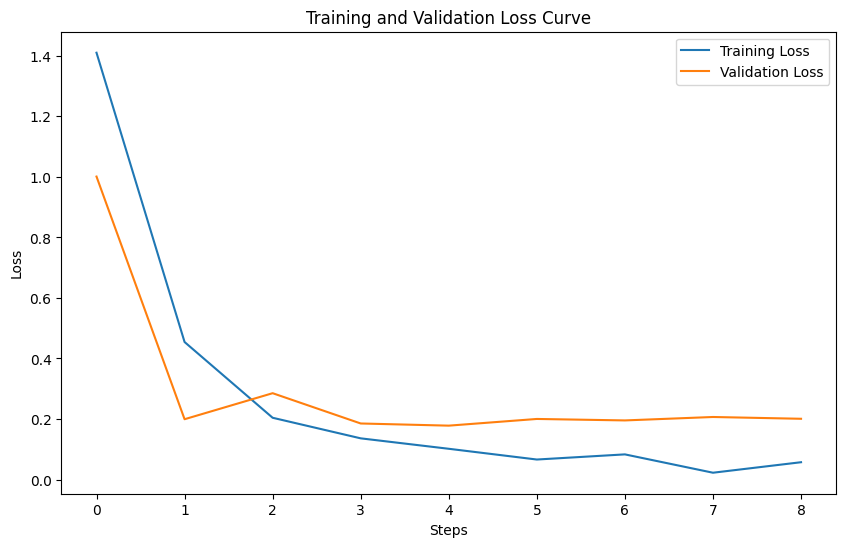

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the training log history
train_loss_values = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss_values = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Use steps for train loss and epochs for eval loss
train_steps = list(range(len(train_loss_values)))
eval_steps = [i * (len(train_steps) // len(eval_loss_values)) for i in range(len(eval_loss_values))]

# Plot both training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss_values, label="Training Loss")
plt.plot(eval_steps, eval_loss_values, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.show()


3 epochs loss curve with no weight decay

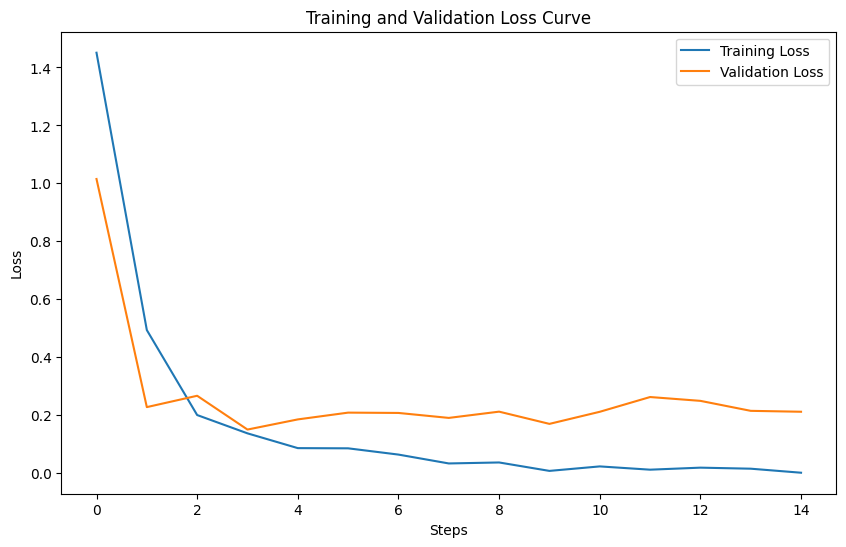

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the training log history
train_loss_values = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss_values = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Use steps for train loss and epochs for eval loss
train_steps = list(range(len(train_loss_values)))
eval_steps = [i * (len(train_steps) // len(eval_loss_values)) for i in range(len(eval_loss_values))]

# Plot both training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss_values, label="Training Loss")
plt.plot(eval_steps, eval_loss_values, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.show()

Loss Curve after 5 epochs with weight decay

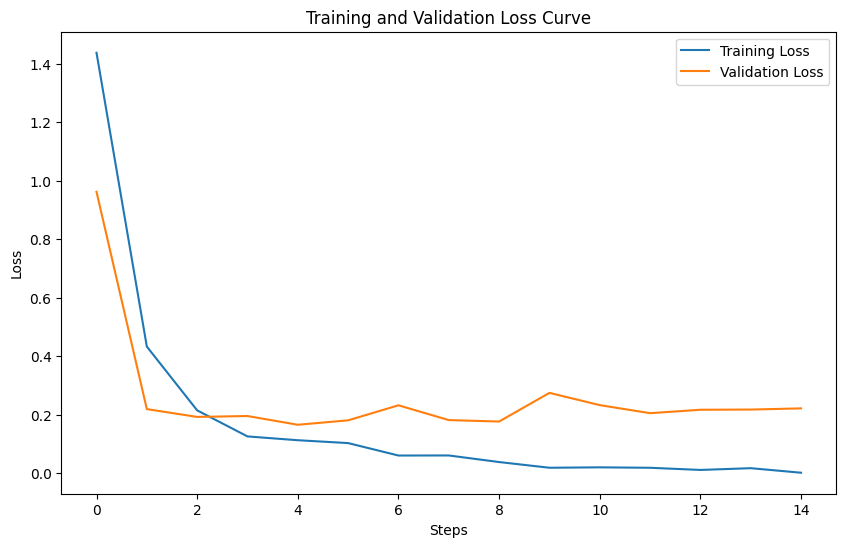

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the training log history
train_loss_values = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss_values = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Use steps for train loss and epochs for eval loss
train_steps = list(range(len(train_loss_values)))
eval_steps = [i * (len(train_steps) // len(eval_loss_values)) for i in range(len(eval_loss_values))]

# Plot both training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss_values, label="Training Loss")
plt.plot(eval_steps, eval_loss_values, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.show()

loss curve of 5 epochs with no weight decay

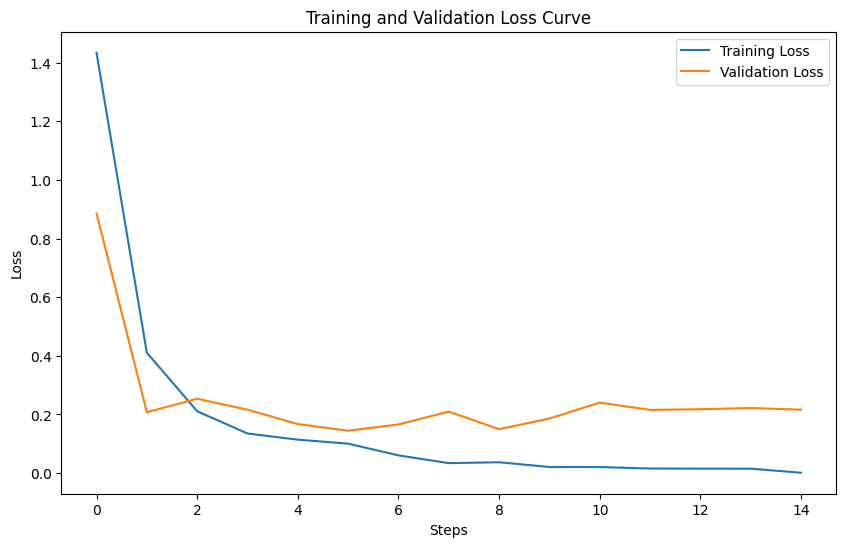

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the training log history
train_loss_values = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss_values = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Use steps for train loss and epochs for eval loss
train_steps = list(range(len(train_loss_values)))
eval_steps = [i * (len(train_steps) // len(eval_loss_values)) for i in range(len(eval_loss_values))]

# Plot both training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss_values, label="Training Loss")
plt.plot(eval_steps, eval_loss_values, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.show()

Loss Curve of 6 epochs with weight decay

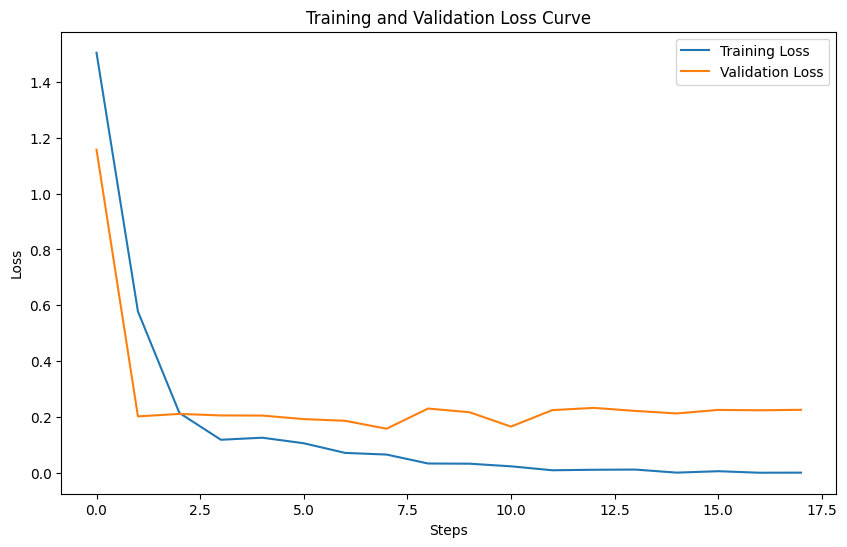

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the training log history
train_loss_values = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss_values = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Use steps for train loss and epochs for eval loss
train_steps = list(range(len(train_loss_values)))
eval_steps = [i * (len(train_steps) // len(eval_loss_values)) for i in range(len(eval_loss_values))]

# Plot both training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss_values, label="Training Loss")
plt.plot(eval_steps, eval_loss_values, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.show()

learning rate of 2e-5 with 6 epochs and weight decay 0.01

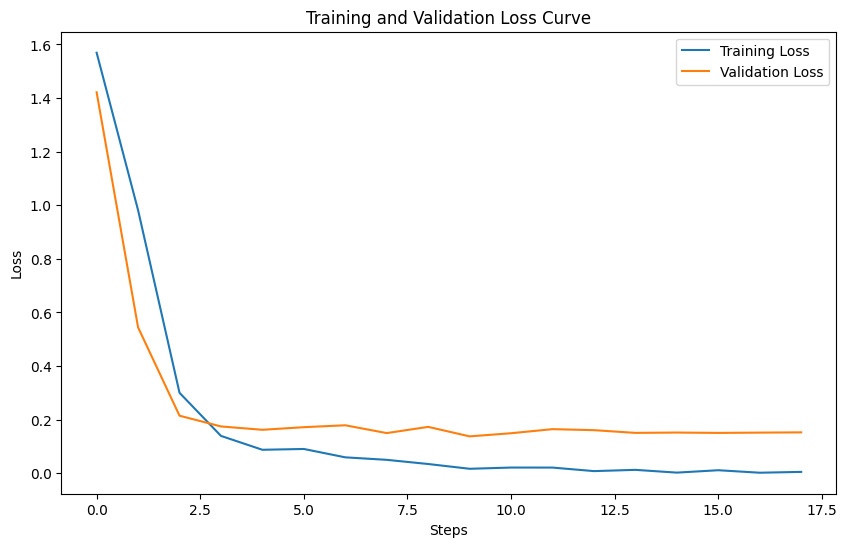

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the training log history
train_loss_values = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss_values = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Use steps for train loss and epochs for eval loss
train_steps = list(range(len(train_loss_values)))
eval_steps = [i * (len(train_steps) // len(eval_loss_values)) for i in range(len(eval_loss_values))]

# Plot both training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss_values, label="Training Loss")
plt.plot(eval_steps, eval_loss_values, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.show()

evaluating the model on the validation dataset

In [ ]:
# Evaluate the model using the validation dataset
evaluation_results = trainer.evaluate()

# # Print the evaluation results
# print(evaluation_results)

# Print each metric separately
print(f"Evaluation Loss: {evaluation_results['eval_loss']}")
print(f"Evaluation Accuracy: {evaluation_results['eval_Accuracy']}")
print(f"Evaluation F1: {evaluation_results['eval_F1']}")
print(f"Evaluation Precision: {evaluation_results['eval_Precision']}")
print(f"Evaluation Recall: {evaluation_results['eval_Recall']}")
print(f"Evaluation Runtime: {evaluation_results['eval_runtime']}")
print(f"Samples per second: {evaluation_results['eval_samples_per_second']}")
print(f"Steps per second: {evaluation_results['eval_steps_per_second']}")

<ipython-input-82-234b08c6df65>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Evaluation Loss: 0.2741324305534363
Evaluation Accuracy: 0.9546925566343042
Evaluation F1: 0.9524210083651573
Evaluation Precision: 0.9517385715864461
Evaluation Recall: 0.9555256452863631
Evaluation Runtime: 9.029
Samples per second: 34.223
Steps per second: 1.108


In [ ]:
# Evaluate the model using the validation dataset
evaluation_results = trainer.evaluate()

# # Print the evaluation results
# print(evaluation_results)

# Print each metric separately
print(f"Evaluation Loss: {evaluation_results['eval_loss']}")
print(f"Evaluation Accuracy: {evaluation_results['eval_Accuracy']}")
print(f"Evaluation F1: {evaluation_results['eval_F1']}")
print(f"Evaluation Precision: {evaluation_results['eval_Precision']}")
print(f"Evaluation Recall: {evaluation_results['eval_Recall']}")
print(f"Evaluation Runtime: {evaluation_results['eval_runtime']}")
print(f"Samples per second: {evaluation_results['eval_samples_per_second']}")
print(f"Steps per second: {evaluation_results['eval_steps_per_second']}")

<ipython-input-11-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Evaluation Loss: 0.1376454383134842
Evaluation Accuracy: 0.9741100323624595
Evaluation F1: 0.9732290503541113
Evaluation Precision: 0.9739423922061494
Evaluation Recall: 0.9734640522875818
Evaluation Runtime: 9.107
Samples per second: 33.93
Steps per second: 1.098


confusion matrix of validation set

<ipython-input-27-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


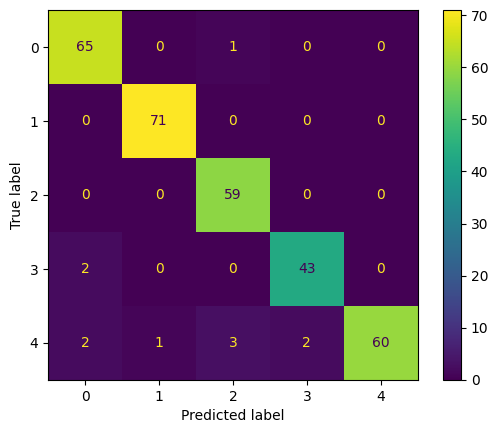

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for the validation dataset
predictions = trainer.predict(val_dataloader)

logits = predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions

# Get the predicted labels (argmax for classification tasks)
preds = np.argmax(logits, axis=1)

# True labels
true_labels = predictions.label_ids

# Create confusion matrix
cm = confusion_matrix(true_labels, preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [ ]:
model_path = "SC4020-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('SC4020-text-classification-model/tokenizer_config.json',
 'SC4020-text-classification-model/special_tokens_map.json',
 'SC4020-text-classification-model/vocab.txt',
 'SC4020-text-classification-model/added_tokens.json',
 'SC4020-text-classification-model/tokenizer.json')

In [ ]:
from transformers import pipeline
from torch import cuda
model_path = "SC4020-text-classification-model"


model = BertForSequenceClassification.from_pretrained(model_path, output_hidden_states=True, num_labels=5)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


3 epochs with no weight decay, weight decay is an important metric in fine-tuning our model

In [ ]:
output = nlp("Donald Trump is the president of the united states of america")

# Post-process the output to map the label ID to its corresponding label name
for result in output:
    label_id = int(result['label'].split('_')[-1])  # Extract the numeric part from the label like 'LABEL_4'
    result['label'] = id2label[label_id]  # Map it to the named label

print(output)

[{'label': 'Business', 'score': 0.39736244082450867}]


3 epochs with weight decay

In [ ]:
nlp("Donald Trump is the president of the united states of america")

[{'label': 'LABEL_4', 'score': 0.8194573521614075}]

5 epochs with no weight decay

In [ ]:
nlp("Donald Trump is the president of the united states of america")

[{'label': 'LABEL_4', 'score': 0.8978576064109802}]

5 epochs with weight decay

In [ ]:
nlp("Donald Trump is the president of the united states of america")

[{'label': 'LABEL_4', 'score': 0.8982625603675842}]

6 epochs with weight decay

In [ ]:
output = nlp("Donald Trump is the president of the united states of america")

# Post-process the output to map the label ID to its corresponding label name
for result in output:
    label_id = int(result['label'].split('_')[-1])  # Extract the numeric part from the label like 'LABEL_4'
    result['label'] = id2label[label_id]  # Map it to the named label
print(output)

[{'label': 'Business', 'score': 0.39736244082450867}]


7 epochs with weight decay

In [ ]:
nlp("Donald Trump is the president of the united states of america")

[{'label': 'LABEL_0', 'score': 0.49811893701553345}]

10 epochs with weight decay, over training results in poor generalisation on test data and over fitting on the train data.

In [ ]:
nlp("Donald Trump is the president of the united states of america")

[{'label': 'LABEL_0', 'score': 0.49811893701553345}]

after 5 epochs the model starts to return wrong predictions

Predicting the test dataset using fine tuned model

<ipython-input-47-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.9836601307189542
Precision: 0.9843929345034723
Recall: 0.9831776472344422
F1-Score: 0.9837242303021203


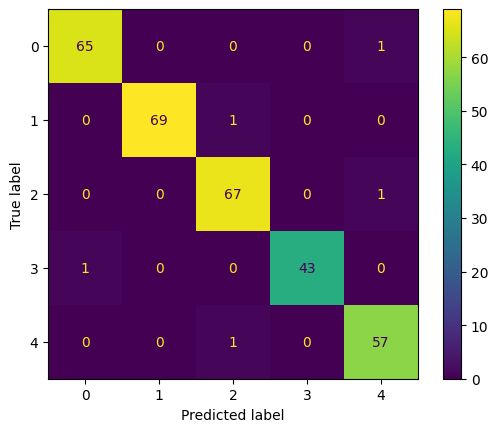

In [ ]:
# Get predictions for the validation dataset
predictions = trainer.predict(test_dataset)

logits = predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions

# Get the predicted labels
preds = np.argmax(logits, axis=1)

# True labels
true_labels = predictions.label_ids

# Calculate accuracy
accuracy = accuracy_score(true_labels, preds)

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='macro')

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Create confusion matrix
cm = confusion_matrix(true_labels, preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

<ipython-input-60-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.9901960784313726
Precision: 0.9903030303030302
Recall: 0.9910873440285204
F1-Score: 0.9905947918343567


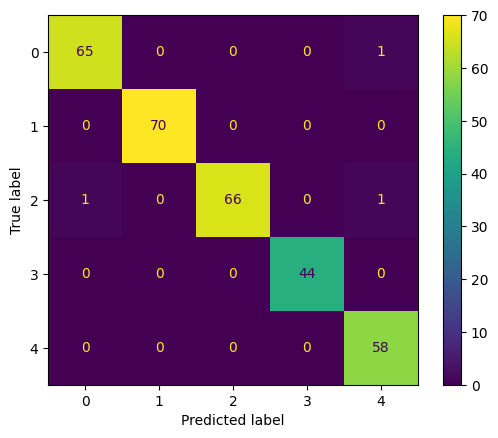

In [ ]:
# Get predictions for the validation dataset
predictions = trainer.predict(test_dataset)

logits = predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions

# Get the predicted labels
preds = np.argmax(logits, axis=1)

# True labels
true_labels = predictions.label_ids

# Calculate accuracy
accuracy = accuracy_score(true_labels, preds)

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='macro')

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Create confusion matrix
cm = confusion_matrix(true_labels, preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

<ipython-input-60-4ee56b40929a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.9836601307189542
Precision: 0.9848842142873094
Recall: 0.983773873185638
F1-Score: 0.9841383050968465


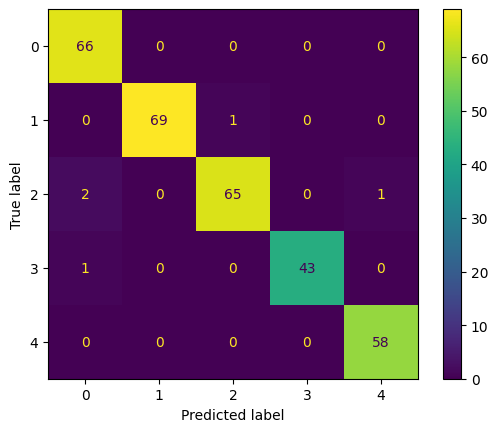

In [ ]:
# Get predictions for the validation dataset
predictions = trainer.predict(test_dataset)

logits = predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions

# Get the predicted labels
preds = np.argmax(logits, axis=1)

# True labels
true_labels = predictions.label_ids

# Calculate accuracy
accuracy = accuracy_score(true_labels, preds)

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='macro')

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Create confusion matrix
cm = confusion_matrix(true_labels, preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

classification report of the test data using fine-tuned model

In [ ]:
report = classification_report(true_labels, preds)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       0.99      0.99      0.99        70
           2       0.97      0.96      0.96        68
           3       0.96      1.00      0.98        44
           4       0.98      0.97      0.97        58

    accuracy                           0.98       306
   macro avg       0.98      0.98      0.98       306
weighted avg       0.98      0.98      0.98       306



In [ ]:
# # Tokenize the input
# inputs = tokenizer(test_df['Text'].tolist(), return_tensors="pt", padding=True, truncation=True)

# # Pass the input through the model
# model.eval()  # Set the model to evaluation mode, so that weights dont update
# with torch.no_grad():
#     outputs = model(**inputs)

# # Extract the hidden states
# hidden_states = outputs.hidden_states  # Tuple of hidden states from each layer

# # Get the last hidden state (BERT output before classification head)
# last_hidden_state = hidden_states[-1]  # Shape: (batch_size, sequence_length, hidden_size)

# cls_embedding = last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)

# # Print the CLS embedding for my test dataset
# print(cls_embedding)


tensor([[ 0.6074,  0.0096,  0.5091,  ...,  1.3258,  0.6026, -1.2505],
        [-0.1998, -1.2815, -0.3319,  ..., -0.3420,  0.1463, -0.9551],
        [-0.6154,  0.8192, -0.1870,  ...,  0.6230,  0.3871, -0.1564],
        ...,
        [ 0.5364,  0.2703,  0.3697,  ...,  1.3202,  0.6234, -1.0304],
        [-0.3521,  0.9181, -0.2203,  ...,  0.5373,  0.5245,  0.0175],
        [ 0.4497,  0.0706,  0.2228,  ...,  1.2368,  0.5374, -1.1735]])


In [ ]:
# # Step 3: Use the embeddings for classification
# training_embeddings = np.stack(train_df['bert_embeddings'].values)
# training_labels = train_df['Label'].values

In [ ]:
# # Assume this is your label to ID mapping
# # label2id = {"Politics": 0, "Sport": 1, "Technology": 2, "Entertainment": 3, "Business": 4}

# # Modify the classify_text_using_cosine_similarity function
# def classify_text_using_cosine_similarity(training_embeddings, training_labels):
#     # Get the BERT embedding for the new text
#     new_embedding = cls_embedding

#     # Compute cosine similarity between new text and all training embeddings
#     similarities = cosine_similarity([new_embedding], training_embeddings)

#     # Find the index of the most similar document in the training set
#     most_similar_index = np.argmax(similarities)

#     # Retrieve the label of the most similar document (numeric)
#     return training_labels[most_similar_index]

# # Predict for the test set using cosine similarity
# predicted_labels = classify_text_using_cosine_similarity(training_embeddings, training_labels)

# # Calculate precision, recall, and F1-score
# precision = precision_score(test_df['Label'].values, predicted_labels, average='weighted')
# recall = recall_score(test_df['Label'].values, predicted_labels, average='weighted')
# f1 = f1_score(test_df['Label'].values, predicted_labels, average='weighted')

# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")


Predicting label for one text document using similarity score

In [ ]:
# new_document = "Donald Trump has become the president of the United States"
# predicted_label = int(classify_text_using_cosine_similarity(new_document, training_embeddings, training_labels))
# predicted_label_str = id2label[predicted_label]
# print(f"The predicted label for the new document is: {predicted_label_str}")

Returning top k items who are most similar to given text

In [ ]:
# # Function to retrieve the top k most similar items and return text, label, and similarity score
# def get_top_k_similar(new_text, df, training_embeddings, k=5):
#     new_embedding = get_bert_embeddings(new_text)
#     similarities = cosine_similarity([new_embedding], training_embeddings).flatten()

#     # Get the indices of the top k most similar documents
#     top_k_indices = similarities.argsort()[-k:][::-1]

#     # top_k_dissimilar_indices = similarities.argsort()[:k]

#     # Retrieve the corresponding texts, labels, and similarity scores
#     top_k_items = [
#         (df.iloc[i]['Text'], df.iloc[i]['Label'], similarities[i])
#         for i in top_k_indices
#         # for i in top_k_dissimilar_indices
#     ]

#     return top_k_items

# # Example usage to get the top 5 most similar documents
# new_document = "Hashtag United Football Club has been formed to compete in the isthmian premier league this season."
# top_k = get_top_k_similar(new_document, df, training_embeddings, k=5)

# # Display the results
# for i, (text, label, similarity) in enumerate(top_k):
#     print(f"Rank {i+1}:")
#     print(f"Text: {text}")
#     print(f"Label: {label}, Similarity: {similarity}")
#     print()
